In [1]:
import qiskit
from qiskit import Aer, QuantumCircuit, execute, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import MCMT
from qiskit.visualization import plot_histogram
import itertools

In [2]:
# Initialize Qasm simulator backend
qasm = Aer.get_backend('qasm_simulator')
backend_sim = qasm

In [3]:
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    for qubit in range(nqubits):
        qc.h(qubit)
    for qubit in range(nqubits):
        qc.x(qubit)
    qc.h(nqubits - 1)
    qc.mct(list(range(nqubits - 1)), nqubits - 1)
    qc.h(nqubits - 1)
    for qubit in range(nqubits):
        qc.x(qubit)
    for qubit in range(nqubits):
        qc.h(qubit)
    U_s = qc.to_gate()
    U_s.name = "$Diff$"
    return U_s

In [4]:
output = ['x', 'sup', 'intric']

lists_final = []
lists_full = list(itertools.permutations(output, len(output)))
for u in lists_full:
    if u not in lists_final:
        lists_final.append(u)
               
lists_final

[('x', 'sup', 'intric'),
 ('x', 'intric', 'sup'),
 ('sup', 'x', 'intric'),
 ('sup', 'intric', 'x'),
 ('intric', 'x', 'sup'),
 ('intric', 'sup', 'x')]

In [5]:
def ram(nqubits, lists_final):
    list_qram = [i for i in range(nqubits)]
    qram = QuantumRegister(nqubits, 'qram')
    qalgo = QuantumRegister(nqubits, 'algo')
    qc = QuantumCircuit(qram, qalgo)
    
    control_h = MCMT('h',nqubits, 1).to_gate()
    
    map_ram_2 = [['x', 'x'], ['o', 'x'], ['x', 'o'], ['o', 'o']]
    map_ram_3 = [['x', 'x', 'x'], ['o', 'x', 'x'], ['x', 'o', 'x'], ['o', 'o', 'x'], 
                 ['x', 'x', 'o'], ['o', 'x', 'o'], ['x', 'o', 'o'], ['o', 'o', 'o']]
    if len(bin(len(lists_final))[2:]) == 3:
        map_ram = map_ram_3
    if len(bin(len(lists_final))[2:]) == 2:
        map_ram = map_ram_2
    
    for i, m_ram in zip(range(len(lists_final)), map_ram):
        #qc.barrier()
        for index, gate in enumerate(m_ram):
            if gate == 'x':
                qc.x(qram[index])
        
        if lists_final[i][0] == 'x' or lists_final[i][0] == 'sup':
            qc.mcx(qram, qalgo[0])
        else:
            qc.append(control_h, [*list_qram, qalgo[0]])
        
        if len(lists_final[i]) == 3:
            if lists_final[i][1] == 'x':
                qc.mcx(qram, qalgo[1])
            elif lists_final[i][1] == 'intric':
                qc.mcx([qram[0], qram[1], qram[2], qalgo[0]], qalgo[1])
            else:
                qc.append(control_h, [*list_qram, qalgo[1]])
            
        if lists_final[i][-1] == 'x':
            qc.mcx(qram, qalgo[-1])
        elif lists_final[i][-1] == 'intric':
            if len(lists_final[i]) == 3:
                qc.mcx([qram[0], qram[1], qram[2], qalgo[1]], qalgo[-1])
            else:
                qc.mcx([qram[0], qram[1], qalgo[0]], qalgo[-1])
        else:
            qc.append(control_h, [*list_qram, qalgo[-1]])
        
        for index, gate in enumerate(m_ram):
            if gate == 'x':
                qc.x(qram[index])
    
    #print(qc.draw())
    U_s = qc.to_gate()
    U_s.name = "$Qram$"
    return U_s

In [6]:
def algo(nqubits):
    qc = QuantumCircuit(nqubits)
    qc.h(0)
    qc.x(0)
    U_s = qc.to_gate()
    U_s.name = "$Algo$"
    return U_s

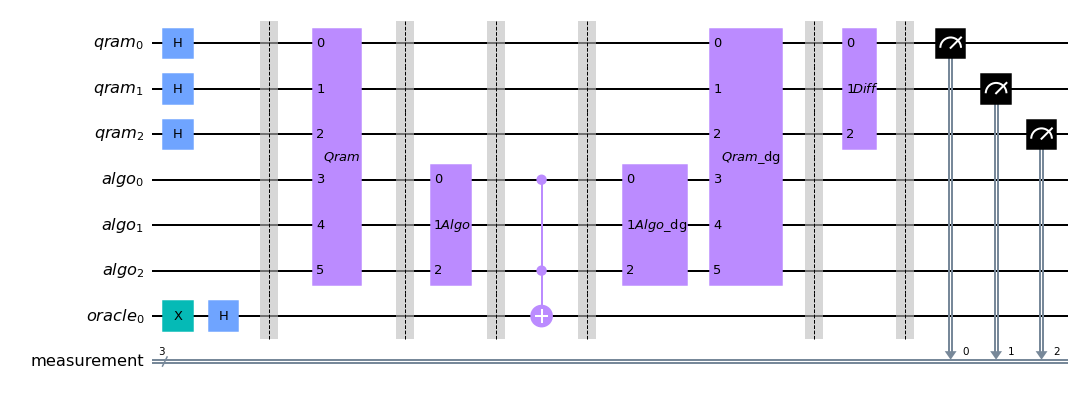

In [7]:
len_qram = len(bin(len(lists_final))[2:])
qram = QuantumRegister(len_qram, 'qram')
qalgo = QuantumRegister(len_qram, 'algo')
oracle = QuantumRegister(1, 'oracle')
c = ClassicalRegister(len_qram, 'measurement')

qc = QuantumCircuit(qram, qalgo, oracle, c)

# Init
qc.h(qram)
qc.x(oracle)
qc.h(oracle)
qc.barrier()

# Qram
qc.append(ram(len_qram, lists_final), [*[i for i in range(len_qram*2)]])
qc.barrier()
# Algorithm
qc.append(algo(len_qram), [*[i for i in range(len_qram, len_qram*2)]])
qc.barrier()

# Oracle
qc.mcx([qalgo[0], qalgo[-1]], oracle)
qc.barrier()

# Revert Algo + Qram
qc.append(algo(len_qram).inverse(), [*[i for i in range(len_qram, len_qram*2)]])
qc.append(ram(len_qram, lists_final).inverse(), [*[i for i in range(len_qram*2)]])
qc.barrier()

# Diffuser
qc.append(diffuser(len_qram), [*[i for i in range(len_qram)]])

# Measure of the ouputs
qc.barrier()
qc.measure(qram, c)

qc.draw(output='mpl')

{'001': 24, '111': 29, '110': 34, '000': 38, '010': 58, '100': 63, '011': 78, '101': 188}


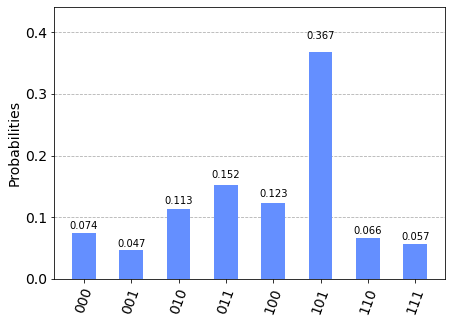

In [15]:
job = execute(qc, backend_sim, shots=512, memory=True)
result_job = job.result()
result_count = result_job.get_counts()
result_memory = job.result().get_memory()
print(dict(sorted(result_count.items(), key=lambda item: item[1])))
plot_histogram(result_count)

In [16]:
if len(result_count) == 1:
        final_result = int(result_memory[0], 2)
else:
    final_result = max(result_count, key=result_count.get)
    final_result = int(final_result, 2)

to_return = lists_final[final_result]
print(to_return)

('intric', 'sup', 'x')
